In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# DONE
#  Extract dataset from the manually downloaded zip file
def extract_dataset():
    # Path to the manually downloaded zip file
    zip_file = 'plant_data.zip'
    extract_folder = "plantvillage_dataset"
    
    # Check if the zip file exists
    if os.path.exists(zip_file) and zip_file.endswith('.zip'):
        # Extract the contents of the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"Dataset extracted to: {extract_folder}")
    else:
        print(f"{zip_file} not found. Please ensure the file is in the same directory as this notebook.")
    return extract_folder

# Call the function to extract the dataset
dataset_dir = extract_dataset()

Dataset extracted to: plantvillage_dataset


In [ ]:
# Done
import os
import shutil
import random

# Base directory where your PlantVillage dataset is stored
base_dir = r'C:\Users\Marinand\OneDrive - Carrier Corporation\Documents\Grad School\Advanced Machine Learning\Week 3\Assignment 3\plantvillage_dataset\PlantVillage'

# The parent directory where you want to store the train and test datasets
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Maximum number of images per class
MAX_IMAGES_PER_CLASS = 200

# Get a list of all the class folders in the base directory
class_folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# Function to split and limit dataset size
def split_and_limit_dataset():
    for class_folder in class_folders:
        # Get the path to the current class folder
        class_path = os.path.join(base_dir, class_folder)
        
        # List all files in the class folder for debugging
        print(f"Files in {class_path}: {os.listdir(class_path)}")
        
        # Create corresponding class folders in train and test directories
        class_train_dir = os.path.join(train_dir, class_folder)
        class_test_dir = os.path.join(test_dir, class_folder)
        
        # Create directories if they don't exist
        if not os.path.exists(class_train_dir):
            os.makedirs(class_train_dir)
        if not os.path.exists(class_test_dir):
            os.makedirs(class_test_dir)
        
        # Get all image files in the class folder (check common image extensions)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG', '.PNG', '.JPEG'))]
        
        # Debug: Print the number of image files found
        #print(f"Found {len(image_files)} images in {class_folder}")
        
        # Limit the number of images to MAX_IMAGES_PER_CLASS
        image_files = random.sample(image_files, min(len(image_files), MAX_IMAGES_PER_CLASS))  # Limit to max images
        
        # Print to debug: List the files in the folder
        #print(f"Class: {class_folder}, Limited Images: {len(image_files)}")
        
        # Shuffle the image files for random splitting
        random.shuffle(image_files)
        
        # Split the images (80% for training, 20% for testing)
        split_index = int(0.8 * len(image_files))
        train_files = image_files[:split_index]
        test_files = image_files[split_index:]
        
        # Move the files to the respective directories
        for train_file in train_files:
            shutil.move(os.path.join(class_path, train_file), os.path.join(class_train_dir, train_file))
        
        for test_file in test_files:
            shutil.move(os.path.join(class_path, test_file), os.path.join(class_test_dir, test_file))
        
        print(f"Moved {len(train_files)} images to {class_train_dir} and {len(test_files)} images to {class_test_dir}")

# Run the split function with the size limit
split_and_limit_dataset()

print("Dataset split and limited to a smaller size.")

Files in C:\Users\Marinand\OneDrive - Carrier Corporation\Documents\Grad School\Advanced Machine Learning\Week 3\Assignment 3\plantvillage_dataset\PlantVillage\Pepper__bell___Bacterial_spot: ['0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG', '006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG', '00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG', '01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG', '0169b9ac-07b9-4be1-8b85-da94481f05a4___NREC_B.Spot 9169.JPG', '018e494e-d2eb-468b-9d02-40219d9f4921___JR_B.Spot 9045.JPG', '01940b6d-7dea-4889-a7b8-a35f4e9bba34___NREC_B.Spot 9120.JPG', '01dfb88b-cd5a-420c-b163-51f5fe07b74d___JR_B.Spot 9091.JPG', '01ebc916-4793-40a3-b5e4-a32687e4fa3d___NREC_B.Spot 9125.JPG', '024623ab-be81-4d99-a653-c3be1495ce8e___JR_B.Spot 8889.JPG', '02baf62e-11e2-4dde-97fb-e369b57d55d3___JR_B.Spot 8971.JPG', '032aa7c4-0a95-4f09-b0bb-1242f4f32d82___NREC_B.Spot 1889.JPG', '03bb7042-3fd5-42e1-aa2c-d51d6843704c___JR_B.Spot 8925.JPG', '0448a2

In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set up ImageDataGenerator for real-time data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize the pixel values to [0, 1]
    rotation_range=20,           # Random rotation of images (in degrees)
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Zoom in/out
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill the areas that are empty after transformations
)

# Set up ImageDataGenerator for testing (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the root directory where the plantvillage dataset is located
dataset_dir = r"C:\Users\Marinand\OneDrive - Carrier Corporation\Documents\Grad School\Advanced Machine Learning\Week 3\Assignment 3\plantvillage_dataset\PlantVillage"

# Define the train and test directories
train_dir = os.path.join(dataset_dir, "train")  # Train folder
test_dir = os.path.join(dataset_dir, "test")    # Test folder

# Flow data from directories for training
train_generator = train_datagen.flow_from_directory(
    train_dir,                # Directory where the training images are stored
    target_size=(150, 150),   # Resize images to 150x150 pixels
    batch_size=32,            # Number of images per batch
    class_mode='categorical'  # For multi-class classification (change to 'binary' for binary classification)
)

# Flow data from directories for testing
test_generator = test_datagen.flow_from_directory(
    test_dir,                 # Directory where the testing images are stored
    target_size=(150, 150),   # Resize images to 150x150 pixels
    batch_size=32,            # Number of images per batch
    class_mode='categorical'  # For multi-class classification (change to 'binary' for binary classification)
)

Found 2361 images belonging to 15 classes.
Found 591 images belonging to 15 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from itertools import product

# Function to build and compile a model with a given set of hyperparameters
def build_model(learning_rate, filters_layer1, filters_layer2, dense_neurons, dropout_rate, kernel_size=(3, 3)):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(filters_layer1, kernel_size, activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(filters_layer2, kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully Connected Layer
    model.add(layers.Dense(dense_neurons, activation='relu'))
    
    # Optional Dropout Layer
    if dropout_rate:
        model.add(layers.Dropout(dropout_rate))
    
    # Output Layer
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define a smaller set of hyperparameters to test
learning_rates = [0.001, 0.0005]  # 2 values for learning rate
filters_layer1_list = [32, 64]  # 2 values for the first layer's filter size
filters_layer2_list = [64, 128]  # 2 values for the second layer's filter size
dense_neurons_list = [64, 128]  # 2 values for dense layer size
dropout_rates = [None, 0.3]  # 2 values for dropout

# Create combinations of key hyperparameters (fewer combinations)
param_combinations = list(product(learning_rates, filters_layer1_list, filters_layer2_list,
                                   dense_neurons_list, dropout_rates))

# Store results
results = {}

# Loop through all combinations of parameters
for i, params in enumerate(param_combinations):
    learning_rate, filters_layer1, filters_layer2, dense_neurons, dropout_rate = params
    print(f"Testing combination {i + 1}/{len(param_combinations)}: {params}")

    # Build model with current hyperparameters
    model = build_model(learning_rate, filters_layer1, filters_layer2, dense_neurons, dropout_rate)

    # Early stopping callback to avoid overfitting
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=2,  # Limiting to a smaller number of epochs for quicker testing
        validation_data=test_generator,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    
    # Store results
    results[i] = {
        "parameters": {
            "learning_rate": learning_rate,
            "filters_layer1": filters_layer1,
            "filters_layer2": filters_layer2,
            "dense_neurons": dense_neurons,
            "dropout_rate": dropout_rate
        },
        "test_accuracy": test_acc
    }
    print(f"Test Accuracy: {test_acc:.4f}")

# Sort results by test accuracy (descending order)
sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1]['test_accuracy'], reverse=True)}

# Print sorted results
for idx, result in sorted_results.items():
    print(f"Combination {idx + 1}: {result['parameters']} -> Test Accuracy: {result['test_accuracy']:.4f}")

Testing combination 1/32: (0.001, 32, 64, 64, None)
Epoch 1/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 619ms/step - accuracy: 0.0861 - loss: 3.0313 - val_accuracy: 0.1371 - val_loss: 2.5423
Epoch 2/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 779ms/step - accuracy: 0.1697 - loss: 2.4974 - val_accuracy: 0.2589 - val_loss: 2.2289
Test Accuracy: 0.2589
Testing combination 2/32: (0.001, 32, 64, 64, 0.3)
Epoch 1/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 54s 647ms/step - accuracy: 0.0677 - loss: 3.1644 - val_accuracy: 0.1218 - val_loss: 2.6187
Epoch 2/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 775ms/step - accuracy: 0.1557 - loss: 2.5674 - val_accuracy: 0.2487 - val_loss: 2.3666
Test Accuracy: 0.2487
Testing combination 3/32: (0.001, 32, 64, 128, None)
Epoch 1/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - accuracy: 0.0772 - loss: 3.3265 - val_accuracy: 0.1574 - val_loss: 2.5324
Epoch 2/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 746ms/step - accuracy: 0.1798 - loss: 2.4929 - val_accuracy: 0.3672 - val_loss: 2.1117
Test Accuracy: 0.3672
Testing co

In [ ]:
# After finding the best combination run the final model
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Function to build and compile a model with a given set of hyperparameters
def build_model(learning_rate, filters_layer1, filters_layer2, dense_neurons, dropout_rate, kernel_size=(3, 3)):
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(filters_layer1, kernel_size, activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(filters_layer2, kernel_size, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully Connected Layer
    model.add(layers.Dense(dense_neurons, activation='relu'))
    
    # Optional Dropout Layer
    if dropout_rate:
        model.add(layers.Dropout(dropout_rate))
    
    # Output Layer
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model



# Manually set your best hyperparameter values here (after testing the combinations)

learning_rate = 0.001 
filters_layer1 = 32
filters_layer2 = 128
dense_neurons = 128
dropout_rate = 0.3

# Build the final model with selected hyperparameters
model = build_model(learning_rate, filters_layer1, filters_layer2, dense_neurons, dropout_rate)

# Early stopping callback to avoid overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Adjust based on your needs
    validation_data=test_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# Output the test accuracy
print(f"Test Accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


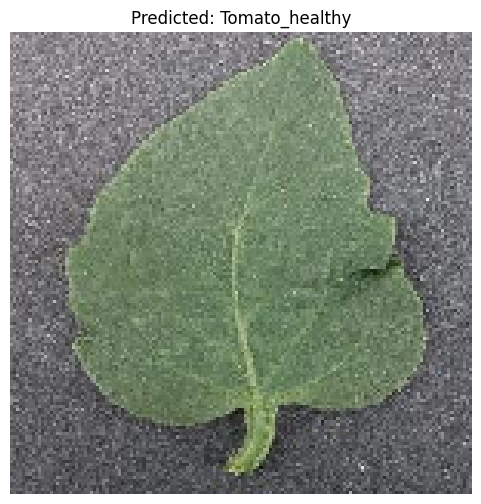

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


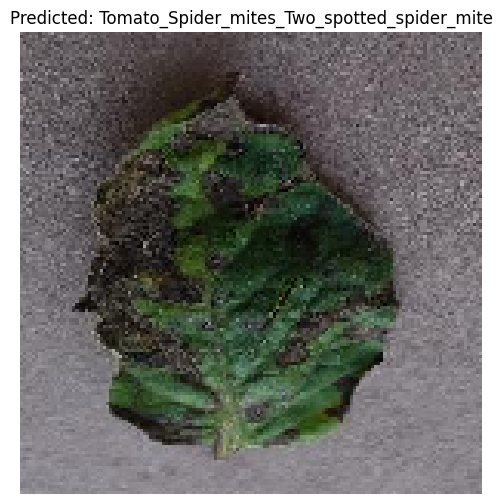

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


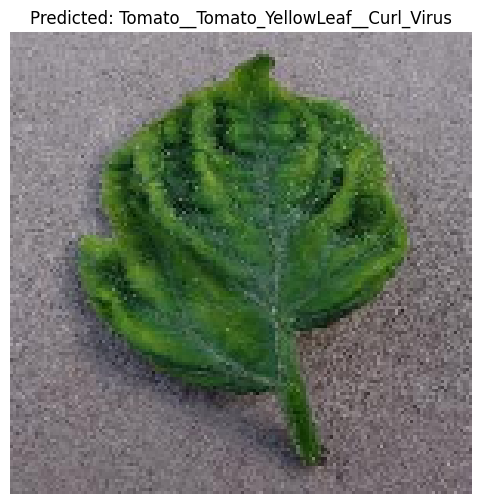

In [10]:
# Get three varied inputs and outputs 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to display image and prediction
def display_predictions(model, test_generator, num_images=3):
    # Get the labels from the test generator
    class_labels = list(test_generator.class_indices.keys())

    # Pick random images from the test set and make predictions
    for i in range(num_images):
        # Select a random image and its label
        random_index = random.randint(0, len(test_generator.filenames) - 1)
        img_path = os.path.join(test_generator.directory, test_generator.filenames[random_index])

        # Load the image and preprocess it for prediction
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img) / 255.0  # Normalize the image
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class of the image
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        # Display the image and predicted class
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Call the display_predictions function to show 3 random images with predictions
display_predictions(model, test_generator, num_images=3)

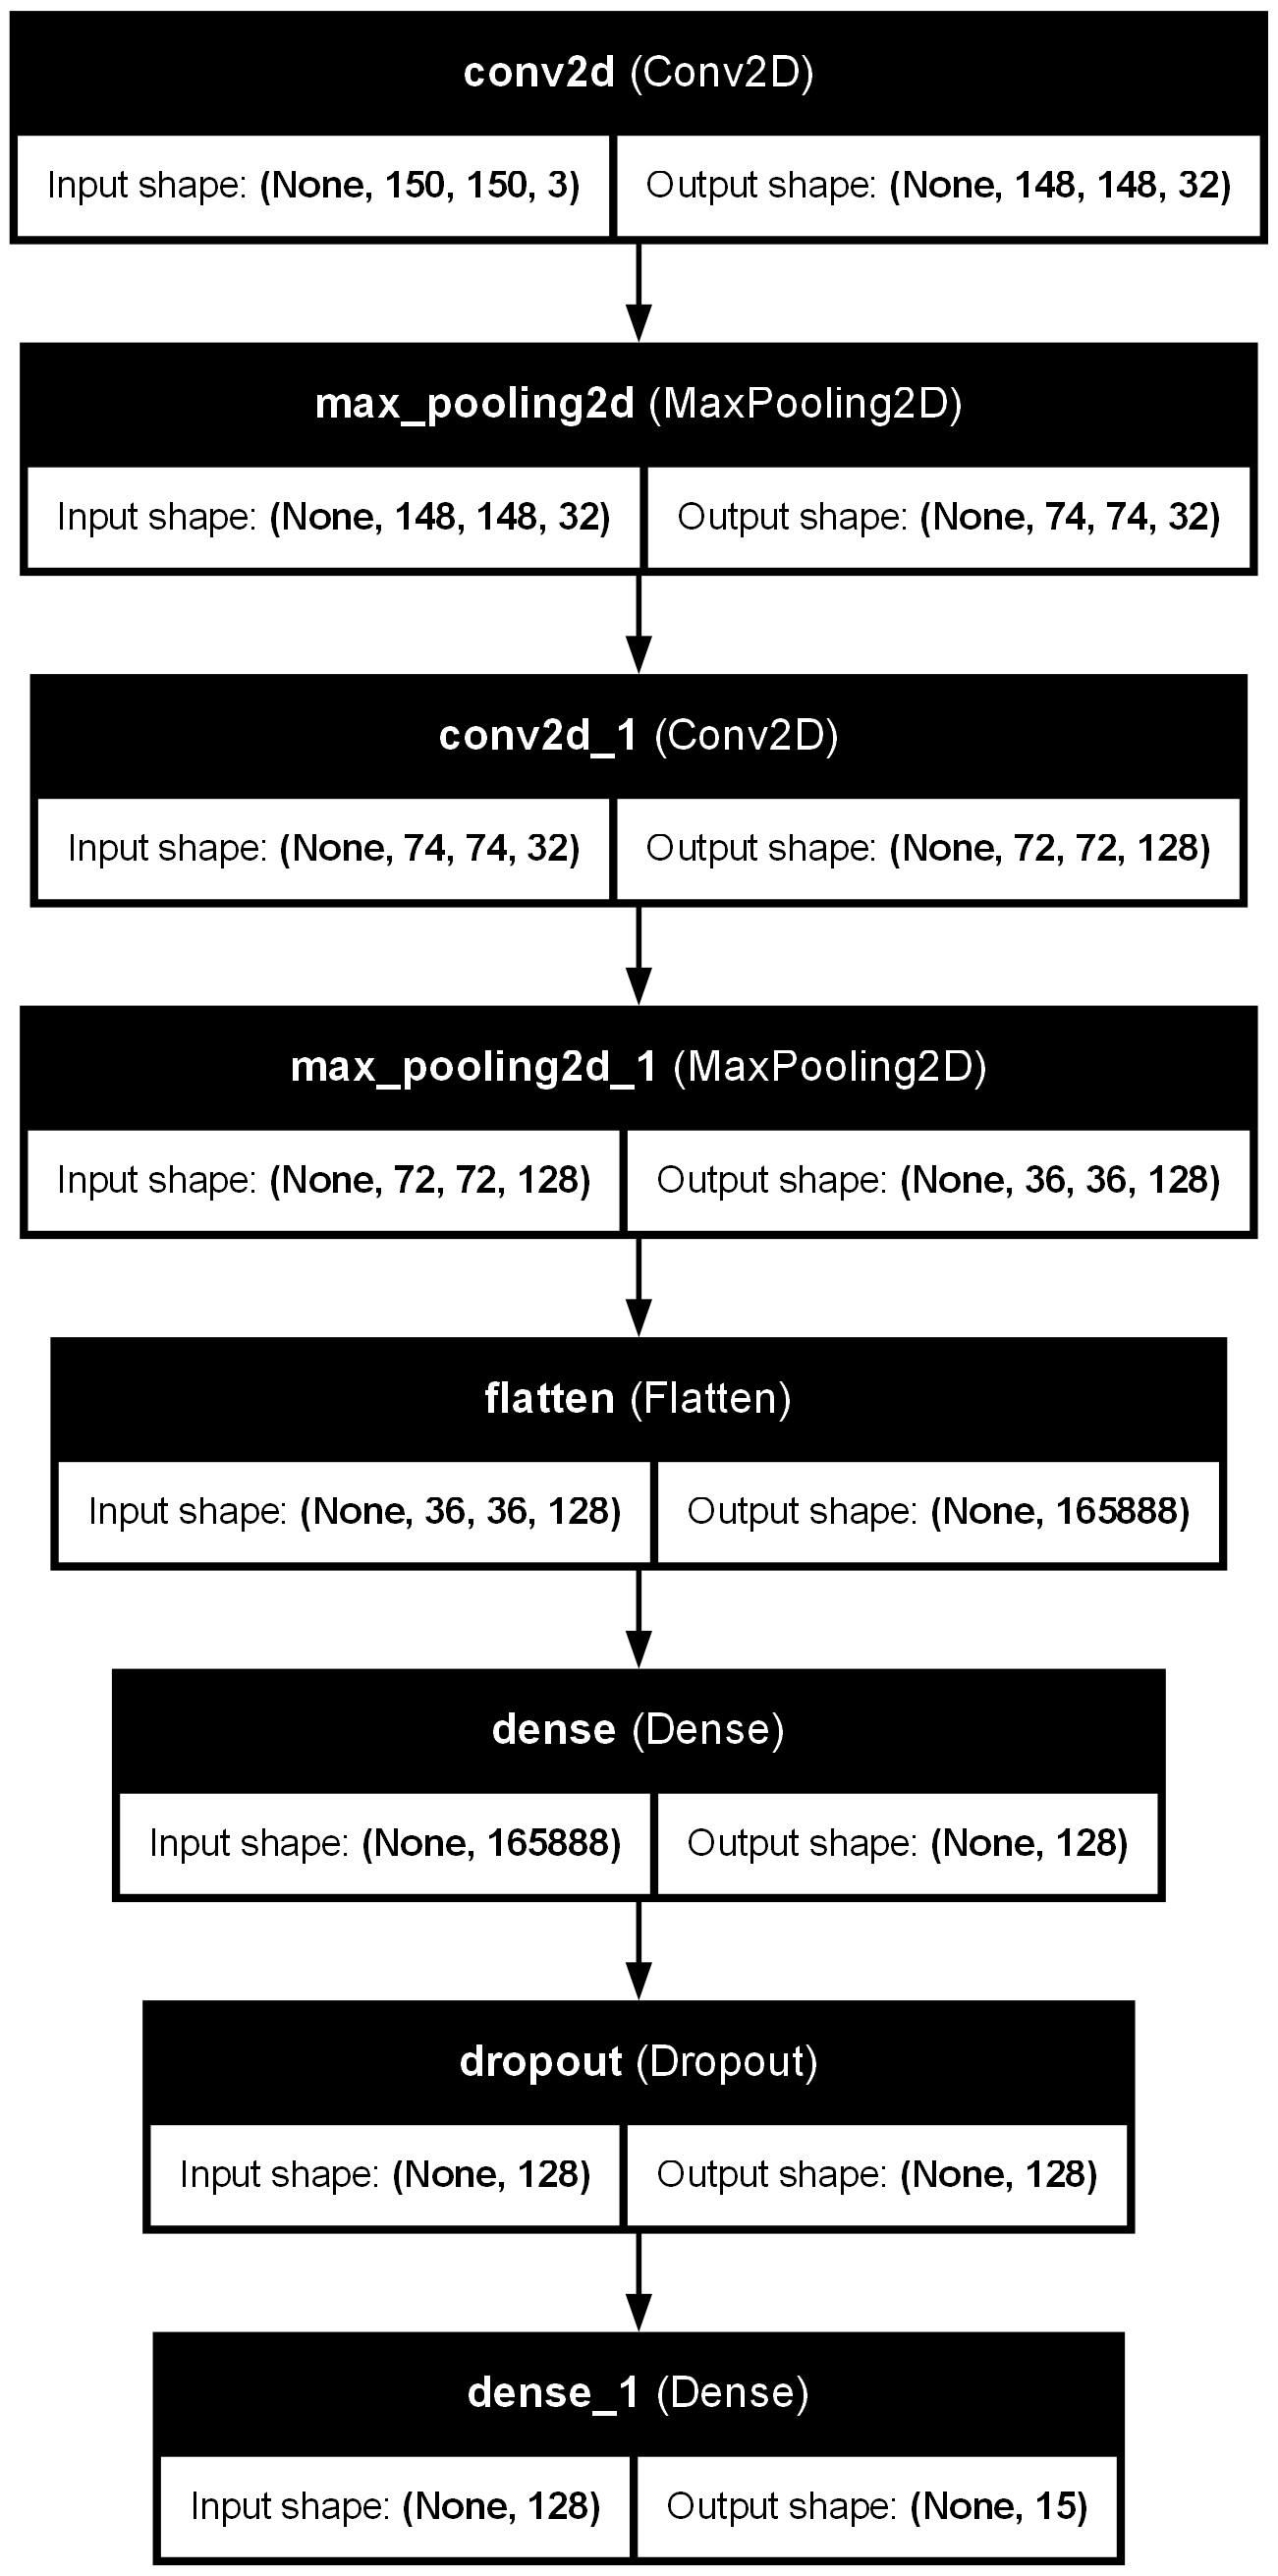

In [4]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture and save it as a PNG image
plot_model(model, to_file='cnn_model_architecture.png', show_shapes=True, show_layer_names=True)